# Text classification: preprocessing text and using it for a spam classification model

Given that language remains a primary means of communication between humans, a lot of extremely useful data come in a natural language form. However, given its complexity and ambiguity, representing these data in a suitable form for automatic processing is a very difficult research challenge. In this exercise, we will get familiar with some basic text analysis techniques. As an exercise, we will try to classify SMS messages for spam detection. The data was downloaded from http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

### 1. Descriptive data analysis

As usual in data science, we will start with descriptive data analysis to understand the data structure and get useful insights. Load the data from `smsspamcollection/SMSSpamCollection.txt` and print the number of spam and non-spam ("ham") messages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load df
df =  pd.read_csv('data/smsspamcollection/SMSSpamCollection.txt', delimiter= '\t', header=None, names = ['type','message'])
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check distribution of data
hamcount = len(df.loc[df.type=='ham'])
spamcount = len(df.loc[df.type=='spam'])
print('The number of ham messages is',hamcount,'\n')
print('The number of spam messages is',spamcount)

The number of ham messages is 4825 

The number of spam messages is 747


Note that the data is imbalanced, which is very common in such types of problems. Now, plot the histogram of message lengths and print average message length for each of the two message types ("ham" and "spam").

In [4]:
#we will do the first part for you, of creating a new column with message lengths :-)
df['message_len'] = df['message'].apply(len)

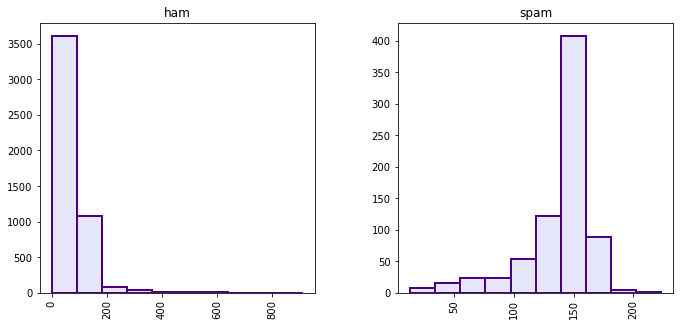

In [5]:
df['message_len'].hist(by=df.type, color='lavender', edgecolor='indigo', linewidth=2, figsize=(11,5))
plt.show()

The very first insight: The spam messages tend to be longer! It might be a useful feature in our classification problem. Let's visualize the most popular words for each category using word clouds. You can use either the `wordcloud` Python package or some external websites such as https://www.wordclouds.com/

In [8]:
# !pip install wordcloud

In [13]:
import wordcloud

# function to intake df filtered on ham or spam, and show a title, using a colormap and background color
def show_wordcloud(data_spam_or_ham, title, colormap, background_color):
    text = ' '.join(data_spam_or_ham['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color=background_color, colormap=colormap).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

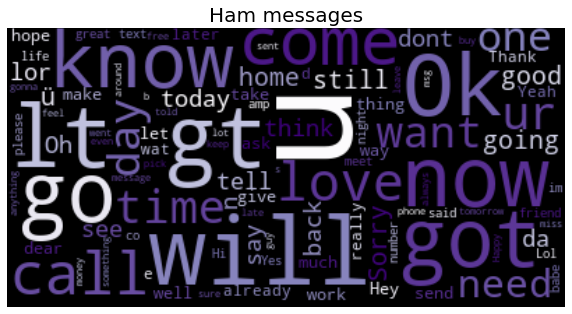

In [14]:
# word cloud of ham messages
show_wordcloud(df[df.type=='ham'], "Ham messages", 'Purples','black')

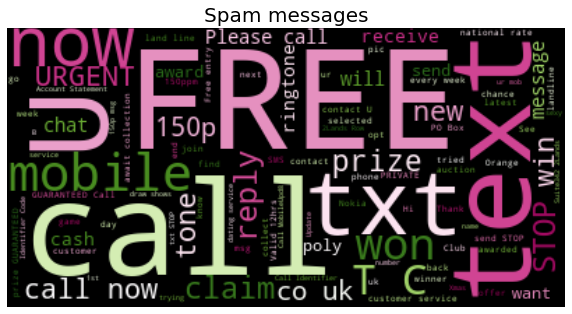

In [19]:
# word cloud of spam messages
show_wordcloud(df[df.type=='spam'], "Spam messages", 'PiYG','black')

These word clouds suggest that using words as features for our classification problem can be a not bad idea.

### 2. Text preprocessing

First, we need to do some text preprocessing, commonly referred to as "normalization". Text preprocessing is usually the most crucial and time-consuming part of the NLP pipeline. In this exercise, it will include the following simple steps:

1. Removing punctuation
2. Converting text to lowercase *(Side note: This step is questionable since spammers tend to use more uppercase letters)*
3. Removing stopwords (either using a predefined list of the English stopwords or using the most frequent words in the text directly)
4. (Optional) Stemming or lemmatizing

This list is, of course, is incomplete and other steps can also include removing rare words, removing numbers, synonymizing, handling negation, etc.

In Python, there are many NLP packages available, such as `NLTK` (the most popular one), `Gensim`, or `spaCy`, however, we will mostly use the basic functionality provided by `sklearn`. For stemming or lemmatizing, one can use the `NLTK` library.

*Side note: In principle, all preprocessing should be done on the train and test sets separately. However, we will skip this **only** for simplicity.*

In [27]:
import string
import nltk
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /Users/alaina/nltk_data...


In [24]:
def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in stopwords])
    
    # lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [25]:
data_df = df.copy()

In [28]:
data_df['message_clean'] = data_df['message'].apply(text_processing)

Print a few messages to check how the preprocessed messages differ from the raw ones.

In [30]:
data_df.sample(5)

,type,message,message_len,message_clean
3095,ham,Have you emigrated or something? Ok maybe 5.30...,67,emigrated something ok maybe 530 bit hopeful
2550,ham,Yup but not studying surfing lor. I'm in e laz...,59,yup studying surfing lor im e lazy mode today
5546,ham,Ic. There are a lotta childporn cars then.,42,ic lotta childporn car
1360,ham,&lt;#&gt; %of pple marry with their lovers... ...,327,ltgt pple marry lover becz hav gud undrstndng ...
2723,ham,It's justbeen overa week since we broke up and...,84,justbeen overa week since broke already brain ...


Let's now represent the text in a format which can be used in machine learning. Since we will use a vector format for the messages ("documents"), this process is called "vectorization". We will use a simple "bag-of-words" (BoW) representation on a single word level (1-grams). First, let's do simple word counts, where `sklearn.feature_extraction.text.CountVectorizer` can be particularly useful. Such vectorizers convert the whole corpora to a document-term matrix of size $N\times M$, where $N$ is a number of documents (messages), $M$ is a vocabulary size (number of different words in the corpora), and each element $d_{ij}$ corresponds to the number (or frequency, or tf-idf, etc) of the word $j$ in the document $i$. Since each document is usually far from containing all the words from vocabulary, the matrix is usually very sparse (has a lot of 0's).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(data_df['message_clean'].values)
print(bow_counts[0])

  (0, 3617)	1
  (0, 4469)	1
  (0, 6091)	1
  (0, 2404)	1
  (0, 1390)	1
  (0, 1830)	1
  (0, 3708)	1
  (0, 8660)	1
  (0, 4621)	1
  (0, 1828)	1
  (0, 2141)	1
  (0, 3670)	1
  (0, 1166)	1
  (0, 8440)	1


Now the vocabulary is all contained in a dictionary called count_vect.vocabulary_. Check it, print its size. It should be close to 9000 (this is a huge number of features!).

In [32]:
len(count_vect.vocabulary_)

8908

In [ ]:
print(count_vect.vocabulary_)

It is often useful to also create the inverse mapping of the vocabulary_. The inverse mapping (let's call it **index_to_word**), is a dictionary where the keys are the indexes, and the values are the words) 

In [34]:
index_to_word = {v: k for k, v in count_vect.vocabulary_.items()}

Now let's weight the term frequencies by inverse document frequency (tf-idf representation). 

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer()
bow_tfidf = tf_transformer.fit_transform(bow_counts)
print(bow_tfidf[0])

  (0, 8660)	0.23716884709034444
  (0, 8440)	0.19898753144041254
  (0, 6091)	0.23830139318791047
  (0, 4621)	0.2948326691905571
  (0, 4469)	0.3489953348778522
  (0, 3708)	0.1942459500636148
  (0, 3670)	0.16378058070686363
  (0, 3617)	0.15482420944980274
  (0, 2404)	0.27027286311810905
  (0, 2141)	0.2948326691905571
  (0, 1830)	0.2948326691905571
  (0, 1828)	0.3331537706947702
  (0, 1390)	0.265382726031558
  (0, 1166)	0.3489953348778522


In [36]:
for b_tfidf, text in zip(bow_tfidf, data_df['message_clean']):
    print(index_to_word[np.argmax(b_tfidf)], "-->", text)

amore --> go jurong point crazy available bugis n great world la e buffet cine got amore wat
oni --> ok lar joking wif u oni
fa --> free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
say --> u dun say early hor u c already say
nah --> nah dont think go usf life around though
chgs --> freemsg hey darling 3 week word back id like fun still tb ok xxx std chgs send £150 rcv
patent --> even brother like speak treat like aid patent
melle --> per request melle melle oru minnaminunginte nurungu vettam set callertune caller press 9 copy friend callertune
claim --> winner valued network customer selected receivea £900 prize reward claim call 09061701461 claim code kl341 valid 12 hour
mobile --> mobile 11 month u r entitled update latest colour mobile camera free call mobile update co free 08002986030
cried --> im gonna home soon dont want talk stuff anymore tonight k ive cried enough today
150pday --> six chance

Having our text normalized and vectorized, let's finally proceed to machine learning!

### 3. Classification

To classify messages as spam/ham (binary classification), we will compare three different sets of features: 
1. Length of messages only
2. Term frequencies (counts)
3. Tf-idf

We will also compare these classifiers to a naive baseline which predicts the most frequent class. Before starting, let us make sure that we have all the features and the target labels ready for the modelling.

In [37]:
X_len = data_df['message_len'].values
X_len = X_len.reshape(-1, 1) # Since we it is single feature
X_bow_counts = bow_counts
X_bow_tfidf = bow_tfidf
y = data_df['type'].apply(lambda x: 1 if x == 'spam' else 0).values
labels = np.array(['ham', 'spam'])

In [38]:
print(X_len.shape)
print(X_bow_counts.shape)
print(X_bow_tfidf.shape)
print(y.shape)

(5572, 1)
(5572, 8908)
(5572, 8908)
(5572,)


We will use 80%/20% train/test split. Note that as the data is imbalanced, this split should be stratified, i.e., the proportion of spam messages in the test set should be the same as in the whole dataset.

In [39]:
# train/test split
from sklearn.model_selection import train_test_split

rs = 42 # reproducible results, set to None for random
(X_len_train, X_len_test, X_bow_counts_train, X_bow_counts_test, 
 X_bow_tfidf_train, X_bow_tfidf_test, y_train, y_test) = train_test_split(
    X_len, X_bow_counts, X_bow_tfidf, y,
    test_size=0.2, stratify=y, random_state=rs)

Check if the proportion of the spam messages is the same in the test set and the whole dataset.

In [40]:
print("Spam/ham ratio in the whole dataset:", np.sum(y) / len(y))
print("Spam/ham ratio in the test set:", np.sum(y_test) / len(y_test))

Spam/ham ratio in the whole dataset: 0.13406317300789664
Spam/ham ratio in the test set: 0.1336322869955157


**Naive baseline**

Always start with the simplest baseline, for example, predicting the most frequent class in the training set. Use standard performance metrics such as confusion matrix and F1 score.

In [41]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [42]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent", random_state=rs)
dummy_classifier.fit(X_len_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

Confusion matrix, without normalization
[[966   0]
 [149   0]]


/Users/alaina/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alaina/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alaina/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

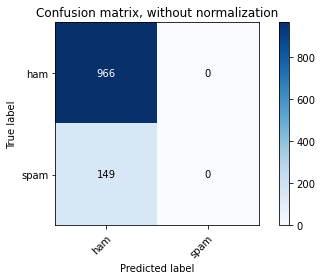

In [43]:
from sklearn.metrics import classification_report
y_pred = dummy_classifier.predict(X_len_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

**Classification using the message length only**

Train classifier which uses the message length as the only feature. Use your favorite model (e.g. Logistic Regression, Support Vector Machine or Neural Net). Remember which implications the data imbalance might have for the model training (e.g., set `class_weight='balanced'` for `sklearn.linear_model.LogisticRegression`). Use standard performance metrics such as confusion matrix and F1 score.

*Optional: If you want, you can balance the training set directly, for instance, using upsampling or downsampling.*

*Optional: You can also tune hyperparameters (e.g. `C` in `sklearn.linear_model.LogisticRegression`), for example, using grid search on the training set based on cross-validation.*

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=10)
lr.fit(X_len_train, y_train)
print(lr.best_params_)

{'C': 0.1}


              precision    recall  f1-score   support

         ham       0.97      0.78      0.87       966
        spam       0.37      0.85      0.52       149

    accuracy                           0.79      1115
   macro avg       0.67      0.82      0.69      1115
weighted avg       0.89      0.79      0.82      1115

Confusion matrix, without normalization
[[753 213]
 [ 22 127]]


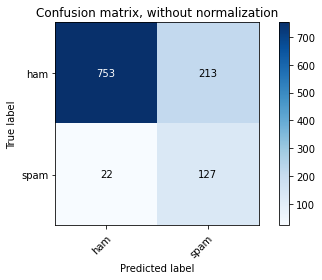

In [45]:
y_pred = lr.predict(X_len_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

**Classification using term frequencies (counts)**

Train classifier which uses the term frequencies as features. Use standard performance metrics such as confusion matrix and F1 score.

In [46]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr2 = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=10)
lr2.fit(X_bow_counts_train, y_train)
print(lr2.best_params_)

{'C': 10}


              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Confusion matrix, without normalization
[[964   2]
 [ 14 135]]


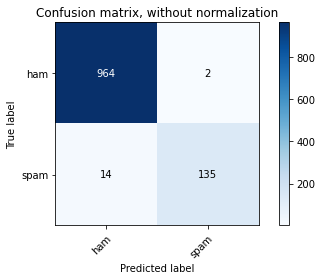

In [47]:
y_pred = lr2.predict(X_bow_counts_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

**Classification using tf-idf matrix**

Train classifier which uses the tf-idf matrix as features. Use standard performance metrics such as confusion matrix and F1 score.

In [48]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=5)
lr.fit(X_bow_tfidf_train, y_train)
print(lr.best_params_)

{'C': 100000000000.0}


              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion matrix, without normalization
[[960   6]
 [ 18 131]]


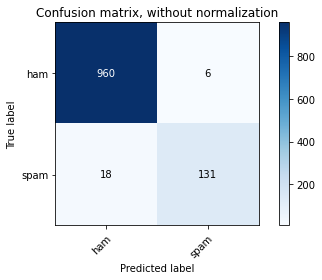

In [49]:
y_pred = lr.predict(X_bow_tfidf_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

Which model performs better? Discuss your results with another student.

One common treatment (but not at all the only one!) an unbalanced dataset is to upsample the lower sample classe(s). Below is a code that you can try. 

### 4. Topic modeling

Topic modeling is a useful set of techniques to represent a document as a set of concepts (or "topics"). Conceptually, it is similar to eigenvector decomposition (Principal Component Analysis, PCA), when each data point (document) is represented as a weighted sum of different eigenvectors (topics). Topics and decompositions are learned by the algorithm in an unsupervised manner. We will use the most popular one -- Latent Dirichlet Allocation (LDA). There are many implementations of the LDA algorithm in different languages and libraries, including `sklearn`.

In [50]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 7  #this is the important K value that you need to decide
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

Let's run the LDA algorithm. Note that it is designed to take term frequency matrix (counts) as an input, however, it is possible to run on tf-idf matrix as well.

In [51]:
X_lda_train = lda.fit_transform(X_bow_counts_train)

Print top N words together with their weights in each topic

In [52]:
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

In [53]:
print("\nTopics in LDA model:")
counts_feature_names = count_vect.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in LDA model:
--------------------------------------------------------------------------------
Topic 0
0.021	ltgt
0.017	ur
0.013	win
0.010	txt
0.008	chance
0.008	voucher
0.007	ya
0.006	hows
0.006	game
0.006	happy
--------------------------------------------------------------------------------
Topic 1
0.014	class
0.012	yo
0.009	went
0.006	drive
0.006	simple
0.005	took
0.004	hold
0.004	test
0.004	project
0.004	right
--------------------------------------------------------------------------------
Topic 2
0.023	call
0.019	free
0.015	text
0.012	reply
0.011	im
0.011	stop
0.010	hi
0.010	new
0.010	good
0.010	day
--------------------------------------------------------------------------------
Topic 3
0.022	im
0.017	ok
0.015	got
0.013	like
0.013	ill
0.011	ltgt
0.010	lor
0.009	later
0.009	still
0.008	sorry
--------------------------------------------------------------------------------
Topic 4
0.041	call
0.019	claim
0.015	prize
0.013	urgent
0.012	cash
0.009	number
0.008	cool
0.008	holiday

/Users/alaina/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Do they have any meaning? Discuss with another student. Try to experiment with different numbers of topics and see how it affects their interpretability.


**Classification using LDA**

Train classifier which uses topic weights for each document (message) as features for the case `n_topics = 7`. Use standard performance metrics such as confusion matrix and F1 score.

In [54]:
X_lda_test = lda.transform(X_bow_counts_test)

In [55]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=5)
lr.fit(X_lda_train, y_train)
print(lr.best_params_)

{'C': 10}


              precision    recall  f1-score   support

         ham       0.97      0.89      0.93       966
        spam       0.53      0.83      0.65       149

    accuracy                           0.88      1115
   macro avg       0.75      0.86      0.79      1115
weighted avg       0.91      0.88      0.89      1115

Confusion matrix, without normalization
[[855 111]
 [ 25 124]]


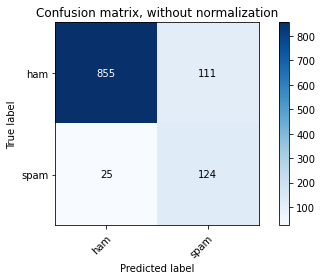

In [56]:
y_pred = lr.predict(X_lda_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()